# Validation

In [7]:
import os
import re
import torch
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from tqdm import tqdm

from networks.resnet_big import SupConResNet, model_dict

### Parameters

In [8]:
cuda_device = 1
tsenecuda_venv = "/home/tgottwald/tsnecuda_venv/"

# dataset
root_train = "./datasets/animals10_300x300/train/"
root_test = "./datasets/animals10_300x300/test/"
mean = (0.3837, 0.3704, 0.3072)
std = (0.3268, 0.3187, 0.3051)

# model checkpoint to validate
# root_model = "./save/SupCon/cifar10_models/SupCon_cifar10_resnet50_lr_0.5_decay_0.0001_bsz_400_temp_0.1_trial_0_cosine_warm/ckpt_epoch_50.pth"
root_model = "./save/SupCon/path_models/SupCon_path_resnet18_lr_0.5_decay_0.0001_bsz_26_temp_0.1_trial_0_try2_cosine/ckpt_epoch_50.pth"

In [9]:
tsenecuda_venv_lib64 = os.path.join(tsenecuda_venv, "lib64")
tsenecuda_venv_interpreter = os.path.join(tsenecuda_venv, "bin/python")

path = root_model.split('/')

for i in range(len(path)):
    if re.fullmatch(
        ".+_.+_lr_[0-9]+(\.[0-9]+)?_decay_[0-9]+\.[0-9]+_bsz_[1-9][0-9]*_temp_[0-9]+(\.[0-9]+)?_trial_[0-9]+(_.+)*",
        path[i]) != None:
        break

# check if checkpoint is in folder with correct name to determent params
assert i < len(path)-1

params = dict()

model_folder = path[i]
folder_split = model_folder.split('_')
params['mode'] = folder_split[0]
params['dataset'] = folder_split[1]
params['model_name'] = folder_split[2]

for j in range(3,13,2):
    params[folder_split[j]] = int(folder_split[j+1]) if (folder_split[j] in ['bsz', 'trial']) else float(folder_split[j+1])

for f in folder_split[13:]:
    params[f] = True

epoch = path[-1].replace(".pth", '').split('_')[-1]

path_embeddings = os.path.join("./save/embeddings/", params['dataset'], model_folder, f"epoch_{epoch}")

### Dataloader and Model

In [5]:
if params['dataset'] == 'cifar10':
    root_train = "./datasets/"
    root_test = "./datasets/"
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
elif params['dataset'] == 'cifar100':
    root_train = "./datasets/"
    root_test = "./datasets/"
    mean = (0.5071, 0.4867, 0.4408)
    std = (0.2675, 0.2565, 0.2761)

In [10]:
normalize = transforms.Normalize(mean=mean, std=std)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

if params['dataset'] == 'cifar10':
    train_dataset = datasets.CIFAR10(root=root_train,
                                     transform=val_transform,
                                     download=True)
    val_dataset = datasets.CIFAR10(root=root_test,
                                   train=False,
                                   transform=val_transform)
elif params['dataset'] == 'cifar100':
    train_dataset = datasets.CIFAR100(root=root_train,
                                      transform=val_transform,
                                      download=True)
    val_dataset = datasets.CIFAR100(root=root_test,
                                    train=False,
                                    transform=val_transform)
elif params['dataset'] == 'path':
    train_dataset = datasets.ImageFolder(root=root_train,
                                         transform=val_transform)
    val_dataset = datasets.ImageFolder(root=root_test,
                                       transform=val_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=params['bsz'], shuffle=False,
    num_workers=16, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=params['bsz'], shuffle=False,
    num_workers=8, pin_memory=True)

Files already downloaded and verified


In [11]:
model = SupConResNet(name=params['model_name'])

ckpt = torch.load(root_model, map_location='cpu')
state_dict = ckpt['model']

new_state_dict = {}
for k, v in state_dict.items():
    k = k.replace("module.", "")
    new_state_dict[k] = v
state_dict = new_state_dict

model = model.cuda(device=cuda_device)

model.load_state_dict(state_dict)

<All keys matched successfully>

### Compute Embedding

In [13]:
if not os.path.isdir(path_embeddings):
    os.makedirs(path_embeddings)

_, embedding_size = model_dict[params['model_name']]

model.eval()

embedding = np.array([])
class_labels = np.array([], dtype=int)
for idx, (images, labels) in enumerate(tqdm(train_loader)):
    images = images.cuda(device=cuda_device, non_blocking=True)

    with torch.no_grad():
        features = model.encoder(images)

    embedding = np.append(embedding, features.cpu().numpy())
    class_labels = np.append(class_labels, labels.numpy())


embedding = embedding.reshape(-1, embedding_size)

entry = {'data': embedding, 'labels': class_labels}
with open(os.path.join(path_embeddings, "embedding_train"), 'wb') as f:
    pickle.dump(entry, f, protocol=-1)


embedding = np.array([])
class_labels = np.array([], dtype=int)
for idx, (images, labels) in enumerate(tqdm(val_loader)):
    images = images.cuda(device=cuda_device, non_blocking=True)

    with torch.no_grad():
        features = model.encoder(images)

    embedding = np.append(embedding, features.cpu().numpy())
    class_labels = np.append(class_labels, labels.numpy())

embedding = embedding.reshape(-1, embedding_size)

entry = {'data': embedding, 'labels': class_labels}
with open(os.path.join(path_embeddings, "embedding_test"), 'wb') as f:
    pickle.dump(entry, f, protocol=-1)

model = model.cpu()

  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


### t-SNE

In [14]:
!CUDA_VISIBLE_DEVICES={cuda_device} LD_LIBRARY_PATH={tsenecuda_venv_lib64} {tsenecuda_venv_interpreter} compute_tsne.py --path {path_embeddings} --epoch {epoch}

Training data
load feature embedding
compute t-SNE embedding
writ t-SNE embedding
Test data
load feature embedding
compute t-SNE embedding
writ t-SNE embedding


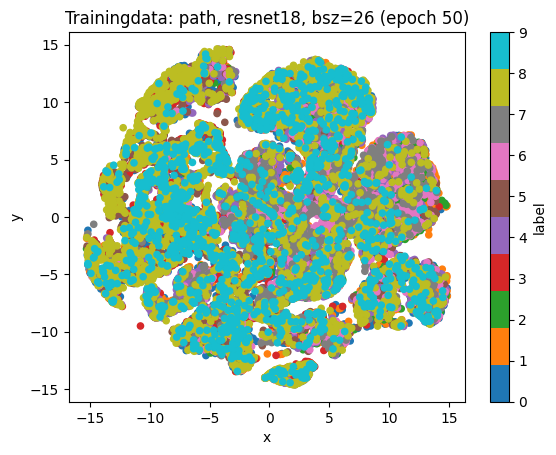

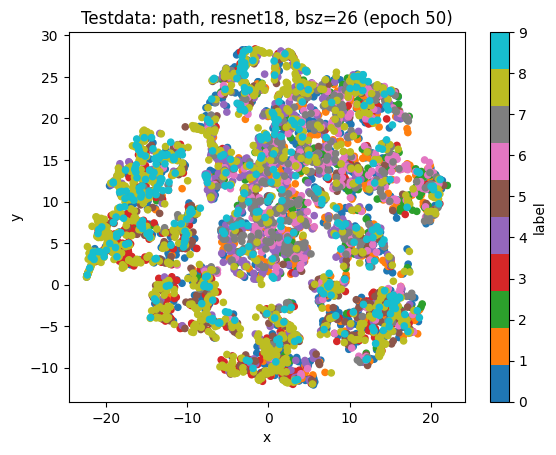

In [11]:
save_plot = False

with open(os.path.join(path_embeddings, "embedding_tSNE_train"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_tSNE_train = entry['data']
    labels_train = entry['labels']
df_train = pd.DataFrame.from_dict({'x': embedding_tSNE_train[:,0], 'y': embedding_tSNE_train[:,1], 'label': labels_train})

with open(os.path.join(path_embeddings, "embedding_tSNE_test"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_tSNE_test = entry['data']
    labels_test = entry['labels']
df_test = pd.DataFrame.from_dict({'x': embedding_tSNE_test[:,0], 'y': embedding_tSNE_test[:,1], 'label': labels_test})

if save_plot:
    df_train.plot.scatter(x='x', y='y', c='label', colormap='tab10',
                          title=f"Trainingdata: {params['dataset']}, {params['model_name']}, bsz={params['bsz']} (epoch {epoch})"
                          ).get_figure().savefig(os.path.join(path_embeddings, "tSNE_epoch_50_train.png"))
    df_test.plot.scatter(x='x', y='y', c='label', colormap='tab10',
                         title=f"Testdata: {params['dataset']}, {params['model_name']}, bsz={params['bsz']} (epoch {epoch})"
                         ).get_figure().savefig(os.path.join(path_embeddings, "tSNE_epoch_50_test.png"))
else:
    fig, axs = plt.subplots(nrows=2, figsize=(7, 10))
    df_train.plot.scatter(x='x', y='y', c='label', colormap='tab10', ax=axs[0],
                        title=f"Trainingdata: {params['dataset']}, {params['model_name']}, bsz={params['bsz']} (epoch {epoch})")
    df_test.plot.scatter(x='x', y='y', c='label', colormap='tab10', ax=axs[1],
                        title=f"Testdata: {params['dataset']}, {params['model_name']}, bsz={params['bsz']} (epoch {epoch})")

### Classifier

In [20]:
classifier_training_call = f"CUDA_VISIBLE_DEVICES={cuda_device} nohup python main_linear.py"\
                          + " --batch_size 256 --batch_size_val 256 --epochs 30 --learning_rate 5"\
                          + f" --model {params['model_name']} --dataset {params['dataset']}"\
                          + f" --data_folder {os.path.join(path_embeddings, 'embedding_train')}"\
                          + f" --test_folder {os.path.join(path_embeddings, 'embedding_test')}"\
                          + " --num_classes 10 --pre_comp_fea"\
                          + f" --tag Epoch{epoch}"\
                          + " > precomp_classifier.out"

In [21]:
!{classifier_training_call}

nohup: ignoring input and redirecting stderr to stdout
